http://incredible.ai/artificial-intelligence/2017/10/28/Deep-Residual-Neural-Network/


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

slim = tf.contrib.slim

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
tf.reset_default_graph()

## Import dataset

In [3]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()

x_train = x_train/255.0
x_train = x_train.astype(dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32)

x_test = x_test/255.0
x_test = x_test.astype(np.float32)
y_test = np.asarray(y_test, dtype=np.int32)

## Split data

In [4]:
train_data_size = 50000
train_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)

x_tr = x_train[train_idx]
y_tr = y_train[train_idx]

x_val = np.delete(arr=x_train, obj=train_idx, axis=0)
y_val = np.delete(arr=y_train, obj=train_idx, axis=0)

print('train data : {}, {}'.format(x_tr.shape, y_tr.shape))
print('val data : {}, {}'.format(x_val.shape, y_val.shape))

train data : (50000, 28, 28), (50000,)
val data : (10000, 28, 28), (10000,)


## Set up dataset with tf.data

In [5]:
batch_size = 32

# for training
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

print(tr_dataset)

# for validation
# validation data의 용량이 in memory에 넣을 수 없을정도로 아래와 같이 활용한다.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 10000)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

print(val_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>


In [6]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                                               tr_dataset.output_types,
                                               tr_dataset.output_shapes)
x, y = iterator.get_next()

## Create the model

Output size

- padding='SAME' : ceil(float(H_in))/float(S)

- padding='VALID' : ceil(float(H_in - F + 1) / float(S))


### tf.layers

In [10]:
def residual_block(input_layer, kernels, filters, stride, is_training):
    """
    input -> Conv -> Relu -> Conv -> Addition -> Relu -> Output
    """
    
    conv = tf.layers.conv2d(input_layer, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=None, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    input_projection = tf.layers.conv2d(input_layer, filters=filters, kernel_size=1, strides=1)
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, input_projection))
    
    conv = tf.layers.conv2d(conv_shortcut_connection, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=tf.nn.relu, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, conv_shortcut_connection))
    
    return tf.layers.max_pooling2d(conv_shortcut_connection, pool_size=2, strides=2, padding='SAME')

In [11]:
def cnn_model(x):
    
    is_training = tf.placeholder(tf.bool)
    
    with tf.variable_scope('input_layer'):
        input_layer = tf.reshape(x, shape=[-1, 28, 28, 1])
        # Now [batch x 28 x 28 x 1]
        conv = tf.layers.conv2d(input_layer, filters=8, kernel_size=3, strides=1, padding='SAME',
                               activation=tf.nn.relu)
        # Now [batch x 28 x 28 x 8]
        
    with tf.variable_scope('residual_1'):
        conv = residual_block(conv, kernels=3, filters=16, stride=1, is_training=is_training)
        # Now [batch x 14 x 14 x 16]
    with tf.variable_scope('residual_2'):
        conv = residual_block(conv, kernels=3, filters=32, stride=1, is_training=is_training)
        # Now [batch x 7 x 7 x 32]
    with tf.variable_scope('residual_3'):
        conv = residual_block(conv, kernels=3, filters=64, stride=1, is_training=is_training)
        # Now [batch x 4 x 4 x 64]
        
    with tf.variable_scope('dense'):
        flatten = tf.reshape(conv, [-1, 4*4*64]) # tf.layer.flatten(conv)
    
        fc1 = tf.layers.dense(flatten, 1024, activation=tf.nn.relu, name='fc1')
        
        dropout = tf.layers.dropout(fc1, rate=0.4, training=is_training, name='dropout')
        logits = tf.layers.dense(dropout, 10, name='logits')
        
        return logits, is_training, input_layer

In [12]:
logits, is_training, x_image = cnn_model(x)

## Define loss and optimizer

In [13]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

## Assign tf.summary.FileWriter

In [14]:
graph_location = 'graphs/tensorflow_resnet'
print('Saving grapg to: %s' % graph_location)
# open FileWriter
train_writer = tf.summary.FileWriter(graph_location)
# add current default graph to the writer
train_writer.add_graph(tf.get_default_graph())

Saving grapg to: graphs/tensorflow_resnet


## tf.summary

In [15]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/cross_entropy', cross_entropy)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    summary_op = tf.summary.merge_all()

## tf.Session() and train

In [16]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 10

for epoch in range(max_epochs):
    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    start_time = time.time()
    
    while True:
        try:
            _, tr_loss = sess.run(fetches = [train_step, cross_entropy],
                               feed_dict = {handle : tr_handle, is_training : True})
            
            
            if tr_step % 100 == 0:
                summary_str = sess.run(summary_op, feed_dict={handle: tr_handle, is_training: False})
                train_writer.add_summary(summary_str, global_step=tr_step)
            tr_step += 1
            avg_tr_loss += tr_loss

        except tf.errors.OutOfRangeError:
            break
    print("Epoch: {} Training Elapsed Time : {}".format(epoch, time.time()-start_time))
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(cross_entropy, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
    
    print('epochs : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

Epoch: 0 Training Elapsed Time : 16.966204404830933
epochs :   1, tr_loss : 0.199, val_loss : 0.110
Epoch: 1 Training Elapsed Time : 14.478538990020752
epochs :   2, tr_loss : 0.067, val_loss : 0.164
Epoch: 2 Training Elapsed Time : 14.591488361358643
epochs :   3, tr_loss : 0.054, val_loss : 0.109
Epoch: 3 Training Elapsed Time : 14.707720041275024
epochs :   4, tr_loss : 0.044, val_loss : 0.106
Epoch: 4 Training Elapsed Time : 14.543276309967041
epochs :   5, tr_loss : 0.038, val_loss : 0.050
Epoch: 5 Training Elapsed Time : 14.468720197677612
epochs :   6, tr_loss : 0.034, val_loss : 0.032
Epoch: 6 Training Elapsed Time : 14.9443039894104
epochs :   7, tr_loss : 0.029, val_loss : 0.056
Epoch: 7 Training Elapsed Time : 14.636051654815674
epochs :   8, tr_loss : 0.028, val_loss : 0.066
Epoch: 8 Training Elapsed Time : 14.487236976623535
epochs :   9, tr_loss : 0.023, val_loss : 0.059
Epoch: 9 Training Elapsed Time : 14.66176962852478
epochs :  10, tr_loss : 0.023, val_loss : 0.044


## Test trained Model

In [16]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [17]:
print('test accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

test accuracy : 98.65%


## Visualize history

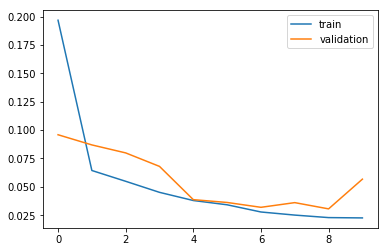

In [18]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()

![title](resnet.PNG)

![title](resnet_2.PNG)

## Slim

In [7]:
def residual_block_slim(input_layer, kernels, filters, stride, is_training):
    
    batch_norm_params = {
        'decay' : 0.997,
        'epsilon' : 1e-5,
        'scale' : True,
        'updates_collections' : tf.GraphKeys.UPDATE_OPS,
        'is_training': is_training
    }
    
    with slim.arg_scope([slim.conv2d], padding='SAME',
                       weights_regularizer=slim.l2_regularizer(scale=0.0001),
                        kernel_size=kernels,
                        num_outputs = filters,
                        stride=stride,
                        normalizer_fn = slim.batch_norm,
                        normalizer_params=batch_norm_params):
        
        net = slim.conv2d(input_layer, scope='conv1')
        net = slim.conv2d(net, activation_fn=None, scope='conv2')
        
        # projection shortcut is used to mactch dimensions
        input_projection = slim.conv2d(input_layer, kernel_size=1, scope='projection')
        shortcut_connection = tf.nn.relu(net+input_projection)
        
        net = slim.conv2d(shortcut_connection, scope='conv3')
        net = slim.conv2d(net, activation_fn=None, scope='conv4')
        
        # idendity shortcut
        shortcut_connection = tf.nn.relu(net+shortcut_connection)
        # subsampling
        return slim.max_pool2d(shortcut_connection, kernel_size=2, stride=2, padding='SAME')  

In [8]:
def cnn_model_slim(x):
    
    is_training = tf.placeholder(tf.bool)
    
    with tf.name_scope('init_conv'):
        x_image = tf.reshape(x, shape=[-1, 28,28,1])
        
        conv = slim.conv2d(x_image, 8, 3, 1, weights_regularizer=slim.l2_regularizer(scale=0.0001))
        
    with tf.variable_scope('residual_1'):
        conv = residual_block_slim(conv, kernels=3, filters=16, stride=1, is_training=is_training)
        
    with tf.variable_scope('residual_2'):
        conv = residual_block_slim(conv, kernels=3, filters=32, stride=1, is_training=is_training)
        
    with tf.variable_scope('residual_3'):
        conv = residual_block_slim(conv, kernels=3, filters=64, stride=1, is_training=is_training)
        
    with tf.variable_scope('dense'):
        flatten = slim.flatten(conv)
        with slim.arg_scope([slim.fully_connected],
                           weights_regularizer = slim.l2_regularizer(scale=0.0001)):
            fc1 = slim.fully_connected(flatten, 1024, scope='fc1')
            dropout = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')
            logits = slim.fully_connected(dropout, 10, activation_fn=None, scope='logits')
    
    return logits, is_training, x_image

In [9]:
logits, is_training, x_image = cnn_model_slim(x)

## Define loss and optimizer

In [11]:
cross_entropy = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=y)
total_loss = slim.losses.get_total_loss()

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer().minimize(total_loss)

Instructions for updating:
Use tf.losses.sparse_softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.


## Assign FileWriter

In [12]:
graph_location = 'graphs/tensorflow_resnet_slim'
print('Saving grapg to: %s' % graph_location)
# open FileWriter
train_writer = tf.summary.FileWriter(graph_location)
# add current default graph to the writer
train_writer.add_graph(tf.get_default_graph())

Saving grapg to: graphs/tensorflow_resnet_slim


## tf.summary

In [13]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/cross_entropy', total_loss)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    summary_op = tf.summary.merge_all()

## tf.Session() and train

In [14]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 10

for epoch in range(max_epochs):
    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    start_time = time.time()
    
    while True:
        try:
            _, tr_loss = sess.run(fetches = [train_step, total_loss],
                               feed_dict = {handle : tr_handle, is_training : True})
            
            
            if tr_step % 100 == 0:
                summary_str = sess.run(summary_op, feed_dict={handle: tr_handle, is_training: False})
                train_writer.add_summary(summary_str, global_step=tr_step)
            tr_step += 1
            avg_tr_loss += tr_loss

        except tf.errors.OutOfRangeError:
            break
    print("Epoch: {} Training Elapsed Time : {}".format(epoch, time.time()-start_time))
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(total_loss, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
    
    print('epochs : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

Epoch: 0 Training Elapsed Time : 24.955445766448975
epochs :   1, tr_loss : 0.249, val_loss : 0.270
Epoch: 1 Training Elapsed Time : 20.924245834350586
epochs :   2, tr_loss : 0.131, val_loss : 0.187
Epoch: 2 Training Elapsed Time : 20.980536460876465
epochs :   3, tr_loss : 0.111, val_loss : 0.133
Epoch: 3 Training Elapsed Time : 20.7476806640625
epochs :   4, tr_loss : 0.101, val_loss : 0.097
Epoch: 4 Training Elapsed Time : 20.709818601608276
epochs :   5, tr_loss : 0.091, val_loss : 0.123
Epoch: 5 Training Elapsed Time : 20.61264395713806
epochs :   6, tr_loss : 0.086, val_loss : 0.104
Epoch: 6 Training Elapsed Time : 20.515162706375122
epochs :   7, tr_loss : 0.081, val_loss : 0.087
Epoch: 7 Training Elapsed Time : 20.3460590839386
epochs :   8, tr_loss : 0.076, val_loss : 0.080
Epoch: 8 Training Elapsed Time : 20.39953064918518
epochs :   9, tr_loss : 0.074, val_loss : 0.085
Epoch: 9 Training Elapsed Time : 20.767143726348877
epochs :  10, tr_loss : 0.072, val_loss : 0.093


In [15]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [25]:
print('test accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

test accuracy : 98.94%


## Visualize histroy

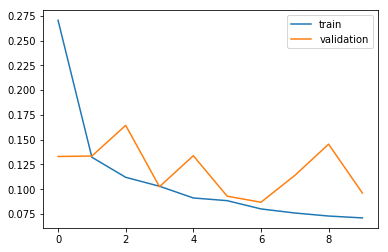

In [16]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()

![title](resnet_slim.PNG)

![title](resnet_slim_2.PNG)